# Regresja liniowa

[Piotr Migdał](http://migdal.wikidot.com/) i Łukasz Jonak, 2015, [DELab UW](http://www.delab.uw.edu.pl/)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("../dane/SkillCraft1_Dataset.csv", na_values=["?"])

In [3]:
# przetwarzamy zgodnie z poprzednim plikiem (dzien4_czesc2_eksploracja_i_wykresy.ipynb)
df = df[df.LeagueIndex < 8]
df = df.loc[:,"LeagueIndex":"APM"]
df = df[df.TotalHours < 100000]
df = df[df.HoursPerWeek > 0]

df_przeskalowane = df[["LeagueIndex"]].copy()
for col in df.columns[1:]:
    df_przeskalowane[col + "_log10"] = np.log10(df[col])
    
df_przeskalowane = df_przeskalowane.dropna()  # usuwamy wiersze z brakującymi danymi

## Prościej

Jest kilka bibiliotek wspierających [regresję liniową](https://en.wikipedia.org/wiki/Linear_regression). Zacznijmy od prostszego podejścia korzystającego z pakietu [StatsModels](http://statsmodels.sourceforge.net/) zawierającego popularne metody statystyczne.

In [4]:
import statsmodels.formula.api as smf

In [5]:
# formuła z wyliczeniem zmiennych; w stylu R-owym
formula = 'LeagueIndex ~ Age_log10 + HoursPerWeek_log10 + TotalHours_log10 + APM_log10'
result = smf.ols(formula, data=df_przeskalowane).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LeagueIndex   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     855.7
Date:                Sun, 19 Jul 2015   Prob (F-statistic):               0.00
Time:                        16:50:34   Log-Likelihood:                -4789.4
No. Observations:                3336   AIC:                             9589.
Df Residuals:                    3331   BIC:                             9619.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             -7.6769      0.403    -19.069      0.000        -8.466    -6.888
Age_log10              0.2472      0.233      1.063      0.288        -0.209     0.703
HoursPerWeek_log10    -0.1889      0.063     -2.981      0.003        -0.313    -0.065
TotalHours_log10       1.0340      0.052     19.788      0.000         0.932     1.136
APM_log10              4.4152      0.108     40.808      0.000         4.203     4.627
==============================================================================
Omnibus:                       38.272   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.805
Skew:                          -0.252   Prob(JB):                     3.75e-09
Kurtosis:                       2.844   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# Gdy wzór jest długi i nie chczemy go przepisywać, możemy prawą stronę zapisać następująco:
" + ".join(df_przeskalowane.columns[1:])

'Age_log10 + HoursPerWeek_log10 + TotalHours_log10 + APM_log10'

Jeśli zaś zależy nam na ważność parametrów, możemy dane przeskalować (zmieniając ich średnie na `0` a wariancje na `1`).

In [7]:
df_z = (df_przeskalowane - df_przeskalowane.mean())/df_przeskalowane.std()

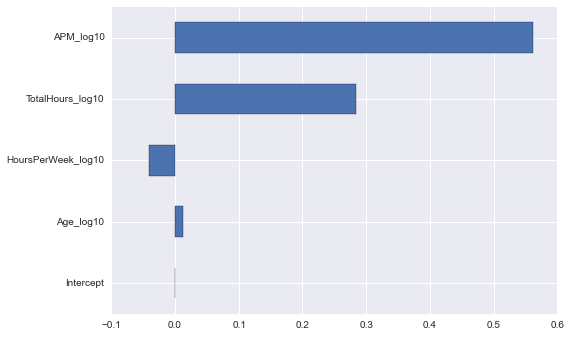

In [8]:
result = smf.ols(formula, data=df_z).fit()
result.params.plot(kind='barh')

Czyli największy wpływ ma liczba akcji na minutę (APM) oraz całkowita liczba przegranych godzin.

## Trudniej

Jeśli zaś czujemy się na siłach, możemy skorzystać z ogólniejszego pakiety - [scikit-learn](http://scikit-learn.org/). O ile w przypadku regresji liniowej to jest trudniejsze podejście, to w ten sam sposób można korzystać z wielu różnych metod statystycznych i uczenia maszynowego.

In [9]:
from sklearn import linear_model

In [10]:
# zamieniamy 'wejscie' ma array X, a 'wyjscie' na array Y 
Y = df_z["LeagueIndex"].values
X = df_z.drop("LeagueIndex", axis=1).values

In [11]:
# array'e to surowe tablice liczb
Y

array([ 0.60773454,  0.60773454, -0.08279762, ..., -0.08279762,
       -0.77332979, -0.08279762])

In [12]:
Y.shape

(3336,)

In [13]:
X

array([[ 1.30076699, -0.30725047,  2.04556989,  0.7400451 ],
       [ 0.4244336 , -0.30725047,  2.60160169,  0.48950975],
       [ 1.87660216, -0.30725047, -0.90213275, -0.95761708],
       ..., 
       [-0.07276166, -0.61776277, -1.6566209 ,  0.34788303],
       [-0.33941841,  1.12550212, -0.14764461,  0.57994989],
       [ 0.18148786, -1.01808276, -0.14764461, -0.39467245]])

In [14]:
X.shape

(3336, 4)

In [15]:
reg = linear_model.LinearRegression()  # tworzymy pusty model
reg.fit(X, Y)  # dopasowujemy model do danych (obiekt 'reg' przechowuje parametry)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [16]:
# współczynnik regresji
reg.coef_

array([ 0.01356574, -0.04071312,  0.28486834,  0.56150114])

In [17]:
wspolczynniki = pd.Series(reg.coef_, index=df_z.columns[1:])
wspolczynniki

Age_log10             0.013566
HoursPerWeek_log10   -0.040713
TotalHours_log10      0.284868
APM_log10             0.561501
dtype: float64

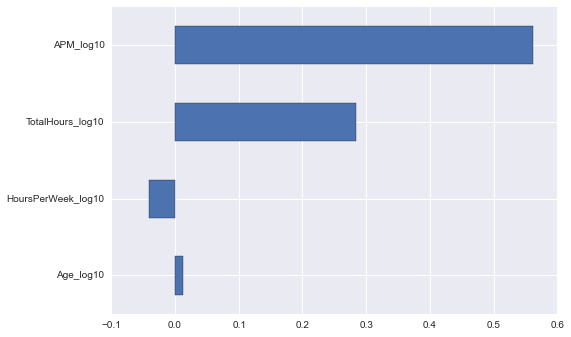

In [18]:
wspolczynniki.plot(kind='barh')

In [19]:
# mozna tez przewidywać dla danych parametrów na wejściu
reg.predict([[1,0,0,0]])

array([ 0.01356574])

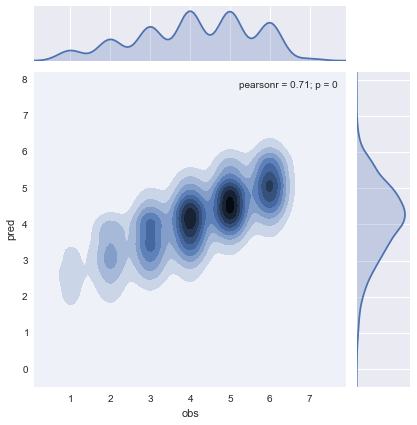

In [20]:
# a jak zobaczyc na ile dobrze potrafimy przewidziec wyniki?

# tworzymy dataframe z prawdziwymi obserwacjami i predykcją
predykcja = pd.DataFrame({'obs': Y, 'pred': reg.predict(X)})

# skalujemy wyniki
predykcja = (predykcja * df_przeskalowane['LeagueIndex'].std()) + df_przeskalowane['LeagueIndex'].mean()

sns.jointplot(x="obs", y="pred", data=predykcja, kind='kde')

## Zobacz też

* [Statistical functions (scipy.stats)¶](http://docs.scipy.org/doc/scipy/reference/stats.html)
* [Probabilistic Programming and Bayesian Methods for Hackers](http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Chapter1.ipynb)